In [2]:
import pickle

from tqdm import tqdm
from glob import glob

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
def check_key_name(key):
    return ('.running_var' not in key) and \
        ('.num_batches_tracked' not in key) and \
        ('.running_mean' not in key) and \
        ('linear.weight' not in key) and \
        ('n_averaged' not in key)

# preparation

In [4]:
# ResNet

with open('./../../drops_with_clean_cifar10/resnet18si_cifar10_usual_metrics.pkl', 'rb') as f:
    usual_tracks = pickle.load(f)

with open('./../../drops_with_clean_cifar10/resnet18si_cifar10_drop_metrics.pkl', 'rb') as f:
    drop_checkpoints = pickle.load(f)

with open('./../../drops_with_clean_cifar10/resnet18si_cifar10_swa_metrics.pkl', 'rb') as f:
    swa_checkpoints = pickle.load(f)

In [5]:
USUAL_ELRS = [
    1e-6, 2e-6, 5e-6, 
    1e-5, 1.4e-5, 2e-5, 3e-5, 5e-5, 7e-5,
    1e-4, 1.4e-4, 2e-4, 3e-4, 5e-4, 7e-4, 
    1e-3, 1.4e-3, 2e-3, 3e-3, 5e-3, 7e-3,
    1e-2, 1.4e-2, 2e-2, 3e-2, 5e-2, 7e-2,
    1e-1, 2e-1, 5e-1,
    1e+0, 2e+0
]

USUAL_ESEEDS = [
    2000, 2001, 2002,
    2003, 2004, 2005, 2006, 2007, 2008,
    2009, 2010, 2011, 2012, 2013, 2014,
    2015, 2016, 2017, 2018, 2019, 2020,
    2021, 2022, 2023, 2024, 2025, 2026,
    2027, 2028, 2029,
    2030, 2031
]

EDLRS = [1e-5, 3e-5, 5e-5, 7e-5, 1e-4, 1.4e-4, 2e-4, 2.5e-4, 3e-4]

In [6]:
cols = sns.color_palette('gist_rainbow',30)
cols = [cols[0],cols[4],cols[12],cols[18],cols[26]]
sns.set_palette(sns.color_palette(cols))
cols = sns.color_palette(cols)
cols

[(1.0, 0.007419183889772136, 0.0),
 (1.0, 0.706942236354001, 0.0),
 (0.0, 1.0, 0.1054185114906178),
 (0.0, 0.8599744245524292, 1.0),
 (0.546675191815857, 0.0, 1.0)]

In [7]:
EDLRS_paper = [EDLRS[0], EDLRS[2], EDLRS[4], EDLRS[6], EDLRS[8]]
ELRS_paper = USUAL_ELRS[3:-4]

fig_shape_x = 6/1.2
fig_shape_y = 3/1.2

# plot averaged 20 epochs

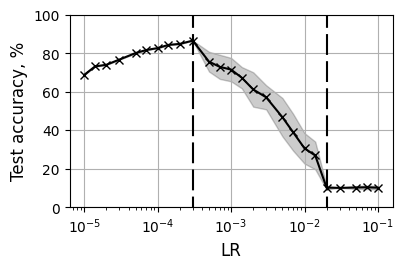

In [24]:
#sns.set_palette(sns.color_palette(cols[::-1]))
map_key_to_label = {
    'loss_trainmode_train': 'train loss',
    'acc_trainmode_train': 'train accuracy',
    'test_loss': 'test loss',
    'test_accuracy': 'test accuracy'
}

for metric_key in ['test_accuracy']:
    fig, ax = plt.subplots(1, 1, figsize=(fig_shape_x/1.2, fig_shape_y))

    ys = []
    stds = []
    xs = []
    for elr in ELRS_paper:
        xs.append(elr)
        tmp = np.array([usual_tracks[elr][i][metric_key] for i in np.arange(181,201)])
        ys.append(tmp.mean())
        stds.append(tmp.std())
        
    ys = np.array(ys)
    stds = np.array(stds)
    ax.plot(xs, ys, color='black', marker='x', label='usual training')
    ax.fill_between(xs,ys-stds,ys+stds,alpha=.2,color='black')
    #ax.plot(xs, ys,  marker='x', label='usual training')
    #ax.fill_between(xs,ys-stds,ys+stds,alpha=.2)
    #ax.errorbar(xs,ys,stds)
    
    ax.set_xlabel('LR',fontsize=12)
    ax.set_ylabel('Test accuracy, %',fontsize=12)
    ax.set_xscale('log')
    ax.grid()
        
    ax.plot([USUAL_ELRS[12], USUAL_ELRS[12]], [0, 100],
              linestyle=(5, (10, 3)), color='black',alpha=1)
    ax.plot([USUAL_ELRS[23], USUAL_ELRS[23]], [0, 100],
              linestyle=(5, (10, 3)), color='black',alpha=1)
    
    if metric_key == 'test_accuracy':
        ax.set_ylim((0, 100))
    
#handles, labels = ax.get_legend_handles_labels()
#ph1 = ax.plot([],marker="", ls="")[0]
#handles = [handles[-1],]+[ph1,] + handles[:-1][::-1]
#labels = ['Pre-train','Fine-tune\nwith DLR:','3.1e-4','1.9e-4','2.0e-5','5.0e-5','1.3e-5']
#ax.legend(handles,labels,loc=(1.03,-0.03),fontsize=12)
    
plt.savefig("./nips_plots/baseline_black.png", bbox_inches='tight', format='png',dpi=512)

# ResNet18SI + CIFAR10

In [25]:
EDLRS_paper

[1e-05, 5e-05, 0.0001, 0.0002, 0.0003]

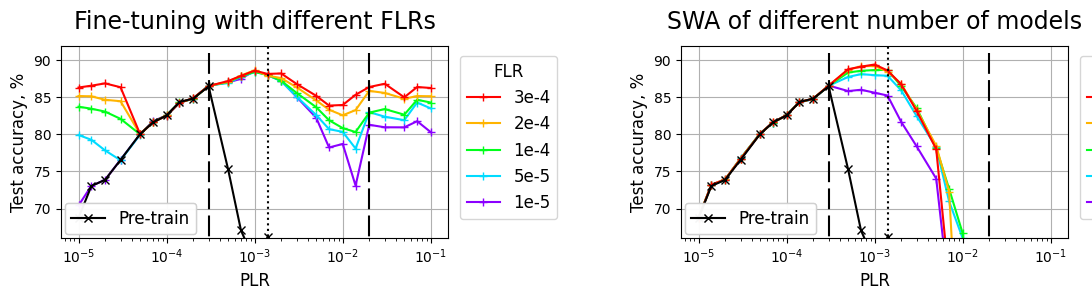

In [33]:
sns.set_palette(sns.color_palette(cols[::-1]))
map_key_to_label = {
    'loss_trainmode_train': 'train loss',
    'acc_trainmode_train': 'train accuracy',
    'test_loss': 'test loss',
    'test_accuracy': 'test accuracy'
}
PRETRAIN_EP = 200
DROP_FROM_EP = 200
DROP_LIST_INDEX = 199


for metric_key in ['test_accuracy']:
    fig, ax = plt.subplots(1, 2, figsize=(fig_shape_x*2*1.3, fig_shape_y))

    for edlr, col in zip(EDLRS_paper, cols[::-1]):
        xs = []
        ys = []
        for elr in ELRS_paper:
            xs.append(elr)
            ys.append(drop_checkpoints[elr][DROP_FROM_EP][edlr][DROP_LIST_INDEX][metric_key])
                
        ax[0].plot(xs, ys, color=col, marker='+', label='{}'.format(edlr))
    
    start_ep = 200
    for k, col in zip([2, 5, 10, 50, 100], cols[::-1]):
        ys = []
        xs = []
        for elr in ELRS_paper:
            xs.append(elr)
            ys.append(swa_checkpoints[elr][start_ep][k][metric_key])
        ax[1].plot(xs, ys, color=col, marker='+', label='SWA[{}:{}:1]'.format(start_ep, start_ep + k))
    
    for i in [0, 1]:
        xs = []
        ys = []
        
        for elr in ELRS_paper:
            xs.append(elr)
            ys.append(usual_tracks[elr][PRETRAIN_EP][metric_key])

        ax[i].plot(xs, ys, color='black', marker='x', label='usual training')

        ax[i].set_xlabel('PLR', fontsize=12)
        ax[i].set_ylabel('Test accuracy, %', fontsize=12)
        ax[i].set_xscale('log')
        ax[i].grid()

        ax[i].plot([USUAL_ELRS[12], USUAL_ELRS[12]], [64, 93],
                  linestyle=(5, (10, 3)), color='black',alpha=1)
        ax[i].plot([USUAL_ELRS[23], USUAL_ELRS[23]], [64, 93],
                  linestyle=(5, (10, 3)), color='black',alpha=1)
        ax[i].plot([USUAL_ELRS[16], USUAL_ELRS[16]], [64, 93],
                'k:',alpha=1)
        ax[i].set_ylim((66, 92))
        


handles, labels = ax[0].get_legend_handles_labels()
labels = ['Pre-train', '3e-4', '2e-4', '1e-4', '5e-5', '1e-5']
legend = ax[0].legend(handles[:-1][::-1],labels[1:],loc=(1.03, 0.1), fontsize=12, title='FLR')
legend_stars = ax[0].legend([handles[-1]],[labels[0]], loc=(0.01, 0.02), fontsize=12)
legend.get_title().set_fontsize('12')
ax[0].add_artist(legend)
ax[0].add_artist(legend_stars)

handles, labels = ax[1].get_legend_handles_labels()
labels = ['Pre-train','100','50','10','5','2']
legend=ax[1].legend(handles[:-1][::-1],labels[1:],loc=(1.03, 0.1),fontsize=12,title='Models')
legend_stars = ax[1].legend([handles[-1]],[labels[0]],loc=(0.01, 0.02),fontsize=12)
legend.get_title().set_fontsize('12')
ax[1].add_artist(legend)
ax[1].add_artist(legend_stars)
    
ax[0].set_title('Fine-tuning with different FLRs', fontsize=17, pad=12)  
ax[1].set_title('SWA of different number of models', fontsize=17, pad=12)  
    
plt.subplots_adjust(wspace=0.6, hspace=0.5)  # ?
# plt.tight_layout()
plt.savefig("./nips_plots/accuracy_resnet18si_cifar10.png", bbox_inches='tight', format='png', dpi=512)

# barriers

In [15]:
with open('./resnet18si_cifar10_barrier_setups.pkl', 'rb') as f:
    barrier_setups = pickle.load(f)

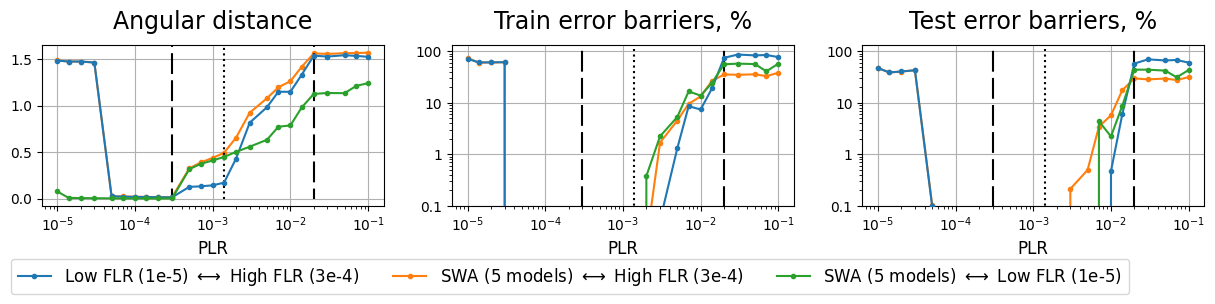

In [32]:
sns.set_palette("tab10")
map_setup_to_label = {
    'interp_drophigh_droplow': 'Low FLR (1e-5) $\longleftrightarrow$ High FLR (3e-4)',
    'interp_swa5_drophigh': 'SWA (5 models) $\longleftrightarrow$ High FLR (3e-4)',
    'interp_swa5_droplow': 'SWA (5 models) $\longleftrightarrow$ Low FLR (1e-5)'
}

fig,ax = plt.subplots(1,3,figsize=(fig_shape_x*3, fig_shape_y/1.2))

for setup in ['interp_drophigh_droplow', 'interp_swa5_drophigh', 'interp_swa5_droplow']:
    xs = []
    ys = []

    for elr in ELRS_paper:
#         if blr > 0.27:
        xs.append(elr)
        ys.append(barrier_setups[setup][elr]['angle'])

    ax[0].plot(xs, ys, marker='.', label=map_setup_to_label[setup])

map_key_to_label = {
    'loss_barrier': 'train loss barrier',
    'lossts_barrier': 'test loss barrier',
    'trainacc_barrier': 'train accuracy barrier',
    'testacc_barrier': 'test accuracy barrier'
}
i=1
for metrickey in ['trainacc_barrier', 'testacc_barrier']:
    for setup in ['interp_drophigh_droplow', 'interp_swa5_drophigh', 'interp_swa5_droplow']:
        xs = []
        ys = []
        for elr in ELRS_paper:
            xs.append(elr)
            if metrickey == 'trainacc_barrier':
                ys.append(barrier_setups[setup][elr][metrickey]*100)
            else:
                ys.append(barrier_setups[setup][elr][metrickey])
        ax[i].plot(xs, ys, marker='.',label = setup) 
    
    ax[i].set_yscale('log')
    ax[i].set_ylim(0.1,130)
    ax[i].set_yticks([0.1,1,10,100])
    ax[i].set_yticklabels(['0.1','1','10','100'])
    i+=1
        
for i in [0,1,2]:
    ax[i].set_xlabel('PLR',fontsize=12)
    ax[i].set_xscale('log')
    ax[i].grid()

    ylim = ax[i].get_ylim();
    ax[i].plot([USUAL_ELRS[12], USUAL_ELRS[12]], [0, 110],
              linestyle=(5, (10, 3)), color='black',alpha=1)
    ax[i].plot([USUAL_ELRS[23], USUAL_ELRS[23]], [0, 110],
              linestyle=(5, (10, 3)), color='black',alpha=1)
    ax[i].plot([USUAL_ELRS[16], USUAL_ELRS[16]], [0, 110],
            'k:',alpha=1)
    ax[i].set_ylim(ylim)
ax[0].set_title('Angular distance',fontsize=17,pad=12)
ax[1].set_title('Train error barriers, %',fontsize=17,pad=12)
ax[2].set_title('Test error barriers, %',fontsize=17,pad=12)


ax[0].legend(loc=(-0.09,-0.55),ncol=3,fontsize=12)

for i in [0,1,2]:
    ax[i].get_lines()[2].set_zorder(4)
    ax[i].get_lines()[0].set_zorder(3)
    ax[i].get_lines()[1].set_zorder(2)
#     for j in [3,4,5]:
#         ax[i].get_lines()[j].set_zorder(5)
plt.subplots_adjust(wspace=0.2,hspace=0.5)

ylim0 = ax[0].get_ylim()
ylim1 = ax[1].get_ylim()
ylim2 = ax[2].get_ylim()
plt.savefig("./nips_plots/geometry.png", bbox_inches='tight', format='png',dpi=512)

# transition

In [35]:
transit_elrs, transit_eps, transit_accs = ([0.0001,
  0.0001,
  0.0001,
  0.00015,
  0.00015,
  0.00015,
  0.0002,
  0.0002,
  0.0002,
  0.00025,
  0.00025,
  0.00025,
  0.0003,
  0.0003,
  0.0003,
  0.00035,
  0.00035,
  0.00035,
  0.00037,
  0.00037,
  0.00038,
  0.00039],
 [18,
  17,
  20,
  25,
  23,
  23,
  27,
  27,
  25,
  40,
  37,
  40,
  90,
  81,
  83,
  336,
  511,
  402,
  501,
  1101,
  1541,
  2621],
 [82.28,
  82.28999999999999,
  82.63000000000001,
  84.41,
  84.65,
  84.17999999999999,
  84.23,
  84.89999999999999,
  84.45,
  85.34,
  85.42,
  85.17,
  86.31,
  85.68,
  85.1,
  86.82,
  86.97,
  86.83999999999999,
  87.22,
  87.41,
  87.07000000000001,
  87.47])

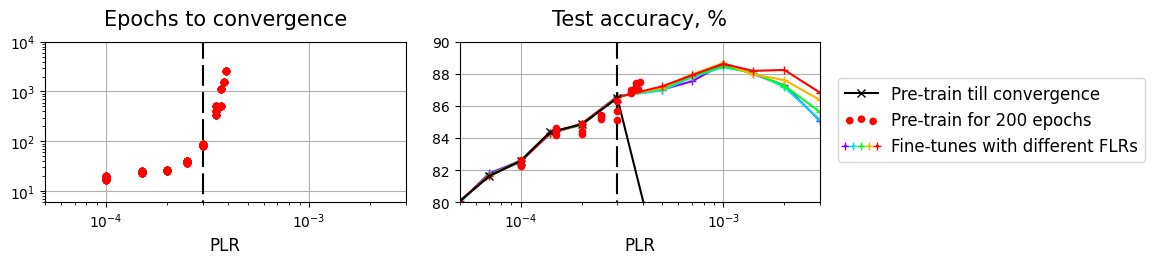

In [37]:
fig,ax = plt.subplots(1,2,figsize=(fig_shape_x*2, fig_shape_y/1.2))
TELRS = []
TMEAN = []
TSTD = []

alp = 1.

PRETRAIN_EP = 200
DROP_FROM_EP = 200
DROP_LIST_INDEX = 199

for blr in transit_epoch_number.keys():
    ax[0].scatter(transit_elrs, transit_eps ,color = cols[0],s=20,zorder=5)
    

#ax[0].errorbar(TELRS, TMEAN, yerr=TSTD, color='black', capsize=4, markeredgewidth=2)  
ax[0].grid()
ax[0].set_title('Epochs to convergence',fontsize=15,pad=12)
ax[0].set_xlabel('PLR',fontsize=12)
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_ylim((6, 10000))

for edlr, col in zip(EDLRS_paper, cols[::-1]):
    xs = []
    ys = []
    for elr in ELRS_paper:
        xs.append(elr)
        ys.append(drop_checkpoints[elr][DROP_FROM_EP][edlr][DROP_LIST_INDEX]['test_accuracy'])

    ax[1].plot(xs, ys, color=col, marker='+', label='{}'.format(edlr))
    
ax[1].scatter(transit_elrs, transit_accs, color = cols[0],s=20,zorder=5,label = 'pre-train for convergence')

for i in [1,]:
    ys = []
    xs = []
    for elr in ELRS_paper:
        xs.append(elr)
        ys.append(usual_tracks[elr][200]['test_accuracy'])

    ax[i].plot(xs, ys, color='black', marker='x', label='usual training',alpha=alp)
    ax[i].set_xlabel('PLR',fontsize=12)
    ax[i].set_title('Test accuracy, %',fontsize=15,pad=12)
    ax[i].set_xscale('log')
    ax[i].grid()

    ax[i].set_ylim((80, 90))

for i in [0,1]:
    ax[i].set_xlim(5e-5,3e-3)
    ax[i].plot([0.0003, 0.0003],[0, 30000],
              linestyle=(5, (10, 3)), color='black')

    
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
handles, labels = ax[1].get_legend_handles_labels()
handles = [handles[-1],handles[5],(handles[0],handles[1],handles[2],handles[3],handles[4])]
labels = ['Pre-train till convergence','Pre-train for 200 epochs','Fine-tunes with different FLRs']
#legend = ax[1].legend(handles[:-1][::-1],labels[1:],loc=(1.03,0.1),fontsize=12,title='FLR')
#legend_stars = ax[1].legend([handles[-1]],[labels[0]],loc='lower right',fontsize=12)
#legend.get_title().set_fontsize('12')
#ax[1].add_artist(legend)
#ax[1].add_artist(legend_stars)

#ax[1].legend([(handles[0],handles[1],handles[2],handles[3],handles[4])],['label'],loc=(1.03,0.1),
#             fontsize=12,scatterpoints=3,handler_map={tuple: HandlerTuple(ndivide=None)})
ax[1].legend(handles,labels,loc=(1.05,0.25),fontsize=12,scatterpoints=3,
             handler_map={tuple: HandlerTuple(ndivide=None)})

plt.subplots_adjust(wspace=0.15,hspace=0.5)
plt.savefig("./nips_plots/1_2_boundary.png", bbox_inches='tight', format='png',dpi=512)

# double drop


In [40]:
import torch

In [38]:
def get_acc(pth: str):
    dd = torch.load(pth)
    return dd['test_res']['accuracy']

In [50]:
noft = [
    get_acc('./../../drops_with_clean_cifar10/Experiments/ResNet18SI_CIFAR10_elri_1e-05_elrd_1e-05_dropepoch_1000_wd_0.0_seed_2003_noaug_True/checkpoint-500.pt'),
    get_acc('./../../drops_with_clean_cifar10/Experiments/ResNet18SI_CIFAR10_elri_0.0003_elrd_0.0003_dropepoch_1000_wd_0.0_seed_2012_noaug_True/checkpoint-500.pt'),
    
]

['No pre-training', 'High PLR (1e-2)', 'High PLR $\\rightarrow$ Low PLR', 'Low PLR (1e-3)']


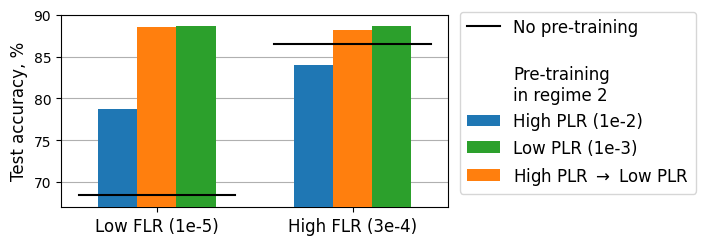

In [55]:
res = [
    get_acc('./../../drops_with_clean_cifar10/Experiments/FIXEDINIT_DROP_ResNet18SI_CIFAR10_elri_0.01_elrd_1e-05_dropepochfrom_200_wd_0.0_seed_2021_noaug_True/checkpoint-400.pt'),
    get_acc('./../../ft_2_stages/Experiments/FIXEDINIT_DROP_ResNet18SI_CIFAR10_elri_0.001_elrd_1e-05_dropepochfrom_400_wd_0.0_seed_3_noaug_True/checkpoint-600.pt'),
    get_acc('./../../drops_with_clean_cifar10/Experiments/FIXEDINIT_DROP_ResNet18SI_CIFAR10_elri_0.001_elrd_1e-05_dropepochfrom_200_wd_0.0_seed_2015_noaug_True/checkpoint-400.pt'),
    
    get_acc('./../../drops_with_clean_cifar10/Experiments/FIXEDINIT_DROP_ResNet18SI_CIFAR10_elri_0.01_elrd_0.0003_dropepochfrom_200_wd_0.0_seed_2021_noaug_True/checkpoint-400.pt'),
    get_acc('./../../ft_2_stages/Experiments/FIXEDINIT_DROP_ResNet18SI_CIFAR10_elri_0.001_elrd_0.0003_dropepochfrom_400_wd_0.0_seed_2_noaug_True/checkpoint-600.pt'),
    get_acc('./../../drops_with_clean_cifar10/Experiments/FIXEDINIT_DROP_ResNet18SI_CIFAR10_elri_0.001_elrd_0.0003_dropepochfrom_200_wd_0.0_seed_2015_noaug_True/checkpoint-400.pt'),    
]


sns.set_palette(sns.color_palette('tab10'))
width = 0.1
multiplier = 0
x = np.arange(2)/2

data_bar = {
    'High PLR (1e-2)': [res[0],res[3]],
    r'High PLR $\rightarrow$ Low PLR': [res[1],res[4]],
    'Low PLR (1e-3)': [res[2],res[5]]
}

fig, ax = plt.subplots(1,1,figsize=(fig_shape_x, fig_shape_y))
ax.grid(axis='y')
for attribute, measurement in data_bar.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute,zorder=5)
    #ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylim(67,90)
ax.set_ylabel('Test accuracy, %',fontsize=12)
ax.set_xticks(x + width);
ax.set_xticklabels(['Low FLR (1e-5)','High FLR (3e-4)'],fontsize=12)

ax.plot([-0.1,0.3],[noft[0], noft[0]],zorder=10, color='black',label='No pre-training')
ax.plot([0.4,0.8],[noft[1], noft[1]],zorder=10, color='black')

handles, labels = ax.get_legend_handles_labels()
print(labels)
ph1 = ax.plot([],marker="", ls="")[0]
legend = ax.legend([handles[0],ph1,handles[1],handles[3],handles[2]],
                   [labels[0],'\nPre-training\nin regime 2',labels[1],labels[3],labels[2]],
                   loc=(1.03,0.07),fontsize=12)
legend.get_title().set_fontsize('12')



plt.savefig("./two_pretrainings.png", bbox_inches='tight', format='png',dpi=512)

In [61]:
def check_key_name_resnet(key):
    return ('.running_var' not in key) and \
        ('.num_batches_tracked' not in key) and \
        ('.running_mean' not in key) and \
        ('linear.weight' not in key) and \
        ('n_averaged' not in key)

In [63]:
def make_flatten_vec(state_dict, layer=None):
    values = []
    if layer is None:
        for key, value in state_dict.items():
            if check_key_name(key):
                values.append(torch.flatten(value))
    else:
        values.append(torch.flatten(state_dict[layer]))
#             print('adding ', value.shape)
    vec = torch.cat(values, 0).to(torch.float64)
    return vec

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

In [62]:
def check_norms_pt_resnet_merged(path_to_ckpt: str, check_key_name, verbose:bool=True):
    data = torch.load(path_to_ckpt, map_location='cpu')

    sd = data['state_dict']
    
#     print(data.keys())

    vec = make_flatten_vec(sd)

    np.linalg.norm(vec)

#     for key in sd.keys():
#         if check_key_name(key):
#             vec = sd[key].ravel()
#             pnorm = np.linalg.norm(vec)

    rho = np.linalg.norm(make_flatten_vec(data['state_dict']).cpu())

    hist_data = []
    for key in sd.keys():
        if check_key_name(key):
            ll = sd[key] / rho             
            for i in range(ll.shape[0]):
                nrm = np.linalg.norm(ll[i, :, :, :].ravel())
                hist_data.append(nrm)
    
    mean_log = np.mean(np.log(hist_data))           
    std_log = np.std(np.log(hist_data))
    
    if verbose:
        bins = np.logspace(np.log10(1e-5),np.log10(1), 51)
        plt.figure(figsize=(12, 6))
        plt.hist(hist_data, bins=bins)
        plt.xscale('log')
        plt.grid()
        plt.title('Norm of parameter groups, merged')
        plt.show()

        print('MEAN(LOG(X)) : {}'.format(mean_log))
        print('STD(LOG(X))  : {}'.format(std_log))   
        
    return hist_data, mean_log, std_log

In [66]:
setups = dict()
hist_data, _, _ = check_norms_pt_resnet_merged(
    './../../drops_with_clean_cifar10/Experiments/ResNet18SI_CIFAR10_elri_0.1_elrd_0.1_dropepoch_1000_wd_0.0_seed_2027_noaug_True/checkpoint-0.pt',
    check_key_name_resnet,
    verbose=False
)
setups['setup_init_usual'] = {'hist_data': hist_data}

hist_data, _, _ = check_norms_pt_resnet_merged(
    './../../drops_with_clean_cifar10/Experiments/ResNet18SI_CIFAR10_elri_0.1_elrd_0.1_dropepoch_1000_wd_0.0_seed_2027_noaug_True/checkpoint-200.pt',
    check_key_name_resnet,
    verbose=False
)
setups['setup_init_3_phase'] = {'hist_data': hist_data}

hist_data, _, _ = check_norms_pt_resnet_merged(
    './../../drops_with_clean_cifar10/Experiments/ResNet18SI_CIFAR10_elri_1e-05_elrd_1e-05_dropepoch_1000_wd_0.0_seed_2003_noaug_True/checkpoint-200.pt',
    check_key_name_resnet,
    verbose=False
)
setups['1e-5_setup_trained_200_from_usual'] = {'hist_data': hist_data}

hist_data, _, _ = check_norms_pt_resnet_merged(
    './../../drops_with_clean_cifar10/Experiments/FIXEDINIT_DROP_ResNet18SI_CIFAR10_elri_0.1_elrd_1e-05_dropepochfrom_200_wd_0.0_seed_2027_noaug_True/checkpoint-400.pt',
    check_key_name_resnet,
    verbose=False
)
setups['1e-5_setup_trained_200_from_3_phase'] = {'hist_data': hist_data}

hist_data, _, _ = check_norms_pt_resnet_merged(
    './../../drops_with_clean_cifar10/Experiments/ResNet18SI_CIFAR10_elri_0.0003_elrd_0.0003_dropepoch_1000_wd_0.0_seed_2012_noaug_True/checkpoint-200.pt',
    check_key_name_resnet,
    verbose=False
)
setups['3e-4_setup_trained_200_from_usual'] = {'hist_data': hist_data}

hist_data, _, _ = check_norms_pt_resnet_merged(
    './../../drops_with_clean_cifar10/Experiments/FIXEDINIT_DROP_ResNet18SI_CIFAR10_elri_0.1_elrd_0.0003_dropepochfrom_200_wd_0.0_seed_2027_noaug_True/checkpoint-400.pt',
    check_key_name_resnet,
    verbose=False
)
setups['3e-4_setup_trained_200_from_3_phase'] = {'hist_data': hist_data}

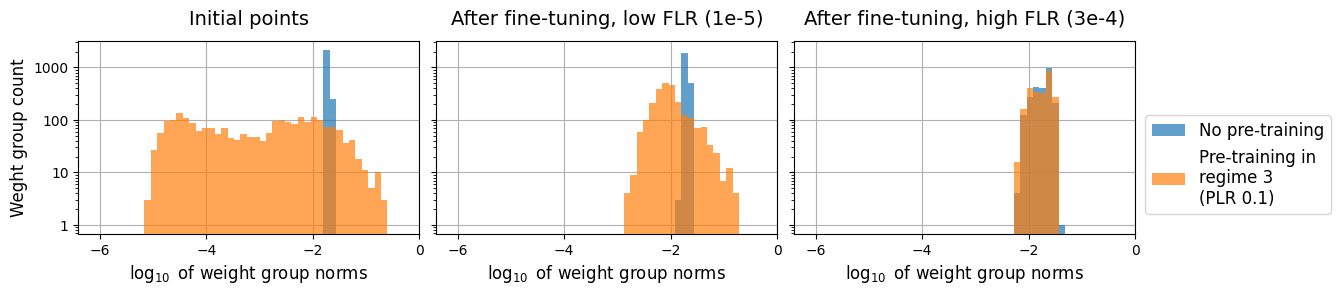

In [71]:
fig,ax = plt.subplots(1,3,figsize=(fig_shape_x*3/1.1, fig_shape_y),sharey=True)
bins = np.linspace(-6, 0, 51)
alp = 0.7
dens = False
                      
ax[0].hist(np.log10(setups['setup_init_usual']['hist_data']), 
         bins=bins, label='baseline init (no train)', alpha=alp, density=dens,zorder=5)

ax[0].hist(np.log10(setups['setup_init_3_phase']['hist_data']), 
         bins=bins, label='BLR({}) 200 ep'.format(0.1), alpha=alp, density=dens,zorder=6)

ax[1].hist(np.log10(setups['1e-5_setup_trained_200_from_usual']['hist_data']),
         bins=bins, label='BLR({}) 200 ep'.format(1e-5), alpha=alp, density=dens,zorder=5)

ax[1].hist(np.log10(setups['1e-5_setup_trained_200_from_3_phase']['hist_data']), 
         bins=bins, label='BLR({}) DROP({})'.format(0.1, 1e-5), alpha=alp, 
           density=dens,zorder=6)

ax[2].hist(np.log10(setups['3e-4_setup_trained_200_from_usual']['hist_data']),
         bins=bins, label='BLR({}) 200 ep'.format(3e-4), alpha=alp, density=dens,zorder=5)

ax[2].hist(np.log10(setups['3e-4_setup_trained_200_from_3_phase']['hist_data']), 
         bins=bins, label='BLR({}) DROP({})'.format(0.1, 2e-4), alpha=alp, 
           density=dens,zorder=6)



for i in [0,1,2]:
    ax[i].set_yscale('log')
    ylim = ax[0].get_ylim()
    ax[i].set_ylim(ylim)
    ax[i].set_xlim(-6.4,0)
    ax[i].set_yticks((1,10,100,1000))
    ax[i].set_yticklabels(('1','10','100','1000'))
    ax[i].set_xticks((-6,-4,-2,0))
    ax[i].set_xlabel(r'$\log_{10}$ of weight group norms',fontsize=12)
    ax[i].grid()
ax[0].set_ylabel('Weght group count',fontsize=12);
ax[0].set_title('Initial points',fontsize=14,pad=12);
ax[1].set_title('After fine-tuning, low FLR (1e-5)',fontsize=14,pad=12);
ax[2].set_title('After fine-tuning, high FLR (3e-4)',fontsize=14,pad=12);

handles, labels = ax[2].get_legend_handles_labels()
labels = ['No pre-training','Pre-training in\nregime 3\n(PLR 0.1)']
legend=ax[2].legend(handles,labels,loc=(1.03,0.1),fontsize=12)
legend.get_title().set_fontsize('12')
 
plt.subplots_adjust(wspace=0.05,hspace=0.5)
plt.savefig("./3_regime_hist.png", bbox_inches='tight', format='png',dpi=512)